# Qiskit Assignment 2

## Elitzur-Vaidman Bomb
Today you will be implementing the EV Bomb experiment.

**NAME**: REPLACE WITH YOUR NAME

**STUDENT ID**: REPLACE WITH YOUR STUDENT ID

In [245]:
from qiskit import *
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
import random
import numpy as np
import math
import matplotlib.pyplot as plt
import re

#### Task 1 - Establishing a Lower Bound
First let's compute the number of iterations through the loop we need to be arbitrarily confident that there won't be an explosion during our experiment. Write a function `compute_iterations` that takes an input `probability`, *in decimal form*, and returns `n`, the number of iterations needed to be (`probability`$\times 100$)% confident that there will **not** be an explosion. Round $n$ to the next highest integer. 

In [199]:
def compute_iterations(probability):
    # BEGIN SOLUTION
    n = (np.pi**2) / (4*(1-probability))
    n = round(n)
    return n
    # END SOLUTION

In [200]:
compute_iterations(0.5) == 5

True

In [201]:
compute_iterations(0.99) == 247

True

In [202]:
compute_iterations(0.99473) == 468

True

In [205]:
# HIDDEN
def testComputeIterations():
    for n in range(1,1000):
        probability = n / 1000
        solution_ans = round((np.pi**2) / (4*(1-probability)))
        student_ans = compute_iterations(probability)
        if student_ans != solution_ans:
            return False
    return True

testComputeIterations() == True

True

#### Task 2 - Computing Theta
We know the number of iterations we need to be arbitrarily confident the bomb won't explode. Now let's calculate the angle we need to rotate through at each step of iteration, $\theta$. Write a function `compute_theta(n)` that takes `n` as input and returns $\theta$. Round $\theta$ to the nearest 5 decimal places.

In [206]:
def compute_theta(n):
    # BEGIN SOLUTION
    theta = np.pi/n
    theta = round(theta,5)
    return theta
    # END SOLUTION

In [207]:
rounding_re = re.compile(r"^([\d]{1}).([\d]{5})$")

def testNumDecimalPlaces():
    theta = compute_theta(10)
    success = True
    return False if rounding_re.match(str(theta)) is None else True
  
testNumDecimalPlaces()

True

In [208]:
compute_theta(15) == 0.20944 and compute_theta(25) == 0.12566

True

In [209]:
# HIDDEN
def testComputeTheta():
    for n in range(1,1000):
        solution_ans = round(np.pi/n,5)
        student_ans = compute_theta(n)
        if student_ans != solution_ans:
            return False
    return True

testComputeTheta() == True

True

#### Task 3 - Rotation
Write a function `rotate(qc,theta)` that takes an input QuantumCircuit `qc`, an input `theta`, and applies a gate to `qc`'s qubit which rotates the state by $\theta$ radians around the $y$-axis of the Bloch sphere.

In [210]:
def rotate(qc, theta):
    # BEGIN SOLUTION
    qc.ry(theta,0)
    # END SOLUTION
    return qc

In [211]:
def testProbabilities1():
    qc = genQC(1)
    theta = np.pi
    qc_rot = rotate(qc, theta).reverse_bits()
    job = execute(qc_rot, BasicAer.get_backend('statevector_simulator'), shots=10)
    return list(job.result().get_statevector(qc))

testProbabilities1()  == [0,1]

True

In [212]:
def testProbabilities2():
    qc = genQC(1)
    theta = np.pi / 2
    qc_rot = rotate(qc, theta).reverse_bits()
    job = execute(qc_rot, BasicAer.get_backend('statevector_simulator'), shots=10)
    return list(job.result().get_statevector(qc))

testProbabilities2() == [1/np.sqrt(2), 1/np.sqrt(2)]

True

In [213]:
def testProbabilities3():
    qc = genQC(1)
    theta = 2* np.pi / 3
    qc_rot = rotate(qc, theta).reverse_bits()
    job = execute(qc_rot, BasicAer.get_backend('statevector_simulator'), shots=10)
    return [round(num, 5) for num in job.result().get_statevector().real]

testProbabilities3() == [round(num, 5) for num in [1/2, np.sqrt(3)/2]]

True

In [217]:
# HIDDEN
em = BasicAer.get_backend("qasm_simulator")
passing = True

for i in range(360):
    theta = i * np.pi/180
    qc_student = rotate(genQC(1), theta)
    
    qc_solution = genQC(1)
    qc_solution.u(theta, 0, 0, getQR(qc_solution))
    
    if not Statevector.from_instruction(qc_student).equiv(Statevector.from_instruction(qc_solution)):
        passing = False
        break

passing == True

True

We use the below method `bomb_oracle()` to randomly decide to include a bomb or not in our experiment.

In [123]:
random.seed(468)

def bomb_oracle():
    if random.random() < 0.5:
        return "bomb"
    else:
        return "empty"

We have provided some other helper methods below. 

`genQC(n)` generates a QuantumCircuit with 1 qubit and n classical bits. 

`identity(qc)` applies an identity gate to `qc`'s qubit. 

`measure(qc, i=0)` applies a measurment from `qc`'s qubit to the $i$th classical bit.

In [115]:
def genQC(n):
    qc = QuantumCircuit()
    qr = QuantumRegister(1,'qr')
    cr = ClassicalRegister(n, 'step')
    rs = ClassicalRegister(1, 'result')
    qc.add_register(qr)
    qc.add_register(cr)
    qc.add_register(rs)
    return qc

def identity(qc):
    qr = getQR(qc)
    qc.id(qr)
    return qc

def measure(qc, i=0):
    qr = getQR(qc)
    cr = getCR(qc, i)
    qc.measure(qr,cr)
    return qc

def getQR(qc):
    return qc.qregs[0]

def getCR(qc, i):
    return qc.cregs[0][i]

#### Task 4  - Putting Things Together
We are now ready to build the full circuit. Write a function `gen_circuit(probability, bomb)` which takes a `probability` that the bomb won't explode, `bomb`--the result of a call to `bomb_oracle()`, and returns a circuit representing the standard EV bomb implementation. For our experiment, we will represent the bomb being present with a measurement and the bomb being absent with an identity. 

Hint: use the provided functions and previous tasks to help build your circuit. Refer to the end of lecture for a description of the implementation.

In [196]:
def gen_circuit(probability, bomb):
    # BEGIN SOLUTION
    n = compute_iterations(probability)
    angle = compute_theta(n)
    qc = genQC(n)
    
    for i in range(n):
        rotate(qc, angle)
        if bomb == "bomb":
            measure(qc,i)
        else:
            identity(qc)
    
    # END SOLUTION
    # Add one final measurement without rotation
    # to the result register
    qc.measure(getQR(qc), qc.cregs[1])
    return qc

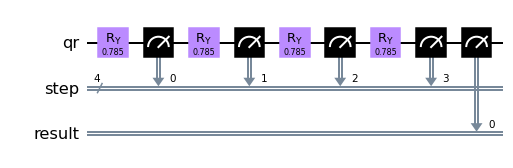

In [218]:
# Draw a bomb circuit here having probability == 0.5
# BEGIN SOLUTION
qc = gen_circuit(0.45, "bomb")
qc.draw(output='mpl')
# END SOLUTION

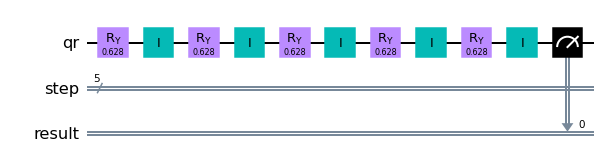

In [219]:
# Draw an empty circuit here having probability == 0.5
# BEGIN SOLUTION
qc = gen_circuit(0.5, "empty")
qc.draw(output='mpl')
# END SOLUTION

#### Task 5  - Testing our Circuit
Run the code below a few times and observe the output. Run each circuit a few times and observe the output. 
- What does measuring $|0\rangle$ or $|1\rangle$ each tell us about the the presence of a bomb?
- Does your circuit blow up a reasonable percentage of the time? Save a chart in your notebook that shows this ratio and describe it in your response below.

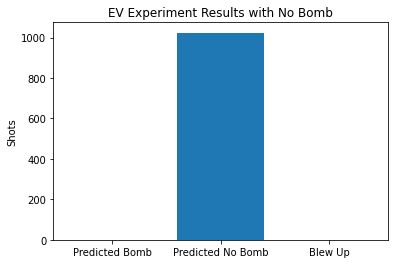

In [258]:
qasm_sim = BasicAer.get_backend("qasm_simulator")

def em(qc, shots=1024):
    job = execute(qc, qasm_sim, shots=shots)
    counts = job.result().get_counts()
    return counts

def run_circuit(percentage,bomb):
    qc = gen_circuit(percentage,bomb)
    qc.draw(output="mpl")
    counts = em(qc)
    n = compute_iterations(percentage)
    
    zeros_key = "0 " + "0"*n
    one_key = "1 "+"0"*n
    
    predicted_bomb = 0
    predicted_no_bomb = 0
    blew_up = 0

    if zeros_key in counts:
        predicted_bomb = counts[zeros_key]
    if one_key in counts:
        predicted_no_bomb = counts[one_key]
        
    blew_up = 1024 - predicted_bomb - predicted_no_bomb
    
    y = np.arange(3)
    plt.bar(y, [predicted_bomb, predicted_no_bomb, blew_up])
    plt.ylabel("Shots")
    plt.xticks(y, ["Predicted Bomb", "Predicted No Bomb", "Blew Up"])
    if bomb == "bomb":
        plt.title("EV Experiment Results with Bomb")
    else:
        plt.title("EV Experiment Results with No Bomb")
    plt.show()
    
    return None

bomb = bomb_oracle()
run_circuit(0.9, bomb)

$|1\rangle$ represents the case of no bomb present. $|0\rangle$ represents the expected state when a bomb is present. If there is a bomb, we'd see it according to the probability established for the trial.

The chart shows that roughly 100 out of 1024 trials resulted in an explosion with a bomb present. This is aligned with the probability set for the experiment.

#### Task 6 (6A, 6B) - EV Bomb on an IBM Quantum Computer
Finally, let's run this circuit on a real IBM quantum computer. In the cell below, run your EV bomb circuit on a machine with at least 5 qubits. Set the probability to be `0.9` and ensure the presence of a bomb.

ibmqfactory.load_account:WARNING:2021-12-28 13:54:48,955: Credentials are already in use. The existing account in the session will be replaced.


Check job status here: https://quantum-computing.ibm.com/jobs/61cb5d7c0e8ecb850119ddaf


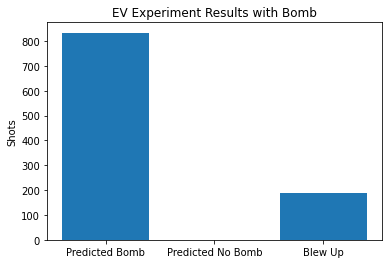

In [257]:
# run your circuit here

# BEGIN SOLUTION
IBMQ.load_account()
ibmqc = IBMQ.get_provider(hub='ibm-q').get_backend('ibmq_lima')
job = execute(gen_circuit(.9, "bomb"), ibmqc, shots=1024)
print("Check job status here:", "https://quantum-computing.ibm.com/jobs/" + job.job_id())
res = job.result()
counts = res.get_counts()
plot_histogram(counts)
# END SOLUTION

n = compute_iterations(.9)
zeros_key = "0 " + "0"*n
one_key = "1 "+ "0"*n

predicted_bomb = 0
predicted_no_bomb = 0
blew_up = 0

if zeros_key in counts:
    predicted_bomb = counts[zeros_key]
if one_key in counts:
    predicted_no_bomb = counts[one_key]

blew_up = 1024 - predicted_bomb - predicted_no_bomb

y = np.arange(3)
plt.bar(y, [predicted_bomb, predicted_no_bomb, blew_up])
plt.ylabel("Shots")
plt.xticks(y, ["Predicted Bomb", "Predicted No Bomb", "Blew Up"])
plt.title("EV Experiment Results with Bomb")
plt.show()

Did your circuit blow up a reasonable percentage of the time on the quantum computer? Save a chart in your notebook that shows this ratio and describe it in your response below. Was there any difference between the simulator and quantum computer results?

The ratio looks similar although there were about twice as many explosions when running on the quantum computer (at least when this solution was made) as in the simulator.

Next time: multi-qubit circuits!